In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nematic-phase/5cb_temp_27.50_copy_0001.jpeg
/kaggle/input/nematic-phase/5cb_temp_27.50_copy_0002.jpeg
/kaggle/input/nematic-phase/5cb_temp_27.50_copy_0005.jpeg
/kaggle/input/nematic-phase/5cb_temp_27.50_copy_0003.jpeg
/kaggle/input/nematic-phase/5cb_temp_25.50_copy_0003.jpeg
/kaggle/input/nematic-phase/5cb_temp_26.50_copy_0002.jpeg
/kaggle/input/nematic-phase/5cb_temp_25.50_copy_0002.jpeg
/kaggle/input/nematic-phase/5cb_temp_26.50_copy_0005.jpeg
/kaggle/input/nematic-phase/5cb_temp_25.50_copy_0005.jpeg
/kaggle/input/nematic-phase/5cb_temp_25.50_copy_0001.jpeg
/kaggle/input/nematic-phase/5cb_temp_25.50_copy_0004.jpeg
/kaggle/input/nematic-phase/5cb_temp_27.50_copy_0004.jpeg
/kaggle/input/nematic-phase/5cb_temp_26.50_copy_0001.jpeg
/kaggle/input/nematic-phase/5cb_temp_26.50_copy_0004.jpeg
/kaggle/input/smectic-phase/5cb_temp_34.1869.jpeg
/kaggle/input/smectic-phase/5cb_temp_31.7576.jpeg
/kaggle/input/smectic-phase/5cb_temp_32.6768.jpeg
/kaggle/input/smectic-phase/5cb_temp_3

In [7]:
!pip install tensorflow keras numpy matplotlib

In [8]:
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
import os


In [9]:
import os
import shutil
import random
import cv2
import numpy as np
import imgaug.augmenters as iaa

# === Paths ===
dataset_5CB_nematic = "/kaggle/input/nematic-phase"
dataset_5CB_isotropic = "/kaggle/input/isotropic-phase"
dataset_5CB_smectic='/kaggle/input/smectic-phase'
output_path = "/kaggle/working/binary1-classification-dataset"

# === Categories ===
categories = {
    "nematic": dataset_5CB_nematic,
    "isotropic": dataset_5CB_isotropic,
    'smectic': dataset_5CB_smectic
}

# === Split ratios ===
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# === Create directory structure ===
for split in ["train", "val", "test"]:
    for category in categories.keys():
        os.makedirs(os.path.join(output_path, split, category), exist_ok=True)

# === Define augmentation pipeline ===
augmenter = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(rotate=(-20, 20), scale=(0.8, 1.2)),
    iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),
    iaa.Multiply((0.8, 1.2)),
    iaa.GammaContrast((0.5, 1.5)),
    iaa.GaussianBlur(sigma=(0, 1.0)),
])

# === Split and augment ===
for category, source_folder in categories.items():
    images = [f for f in os.listdir(source_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)

    train_split = int(train_ratio * len(images))
    val_split = int(val_ratio * len(images))

    for i, img_name in enumerate(images):
        img_path = os.path.join(source_folder, img_name)
        img = cv2.imread(img_path)

        if img is None:
            print(f"❌ Skipping unreadable image: {img_name}")
            continue

        if i < train_split:
            split = "train"
        elif i < train_split + val_split:
            split = "val"
        else:
            split = "test"

        # Base filename
        base, ext = os.path.splitext(img_name)
        base_filename = f"{category}_{i}"

        # Save original image
        dst_dir = os.path.join(output_path, split, category)
        original_path = os.path.join(dst_dir, f"{base_filename}_orig.jpg")
        cv2.imwrite(original_path, img)

        # Generate and save 9 augmentations (total = 10 images per original)
        aug_images = augmenter(images=[img] * 9)
        for j, aug_img in enumerate(aug_images):
            aug_path = os.path.join(dst_dir, f"{base_filename}_aug{j+1}.jpg")
            cv2.imwrite(aug_path, aug_img)

        print(f"✅ {split.upper()} - {category} - {img_name} augmented")

print(f"\n🎉 Dataset split and augmented successfully at: {output_path}")


✅ TRAIN - nematic - 5cb_temp_27.50_copy_0002.jpeg augmented
✅ TRAIN - nematic - 5cb_temp_27.50_copy_0001.jpeg augmented
✅ TRAIN - nematic - 5cb_temp_27.50_copy_0003.jpeg augmented
✅ TRAIN - nematic - 5cb_temp_25.50_copy_0001.jpeg augmented
✅ TRAIN - nematic - 5cb_temp_26.50_copy_0005.jpeg augmented
✅ TRAIN - nematic - 5cb_temp_27.50_copy_0004.jpeg augmented
✅ TRAIN - nematic - 5cb_temp_26.50_copy_0002.jpeg augmented
✅ TRAIN - nematic - 5cb_temp_25.50_copy_0004.jpeg augmented
✅ TRAIN - nematic - 5cb_temp_25.50_copy_0003.jpeg augmented
✅ VAL - nematic - 5cb_temp_26.50_copy_0001.jpeg augmented
✅ VAL - nematic - 5cb_temp_27.50_copy_0005.jpeg augmented
✅ TEST - nematic - 5cb_temp_26.50_copy_0004.jpeg augmented
✅ TEST - nematic - 5cb_temp_25.50_copy_0005.jpeg augmented
✅ TEST - nematic - 5cb_temp_25.50_copy_0002.jpeg augmented
✅ TRAIN - isotropic - 5cb_temp_39.00_copy_0002.jpeg augmented
✅ TRAIN - isotropic - 5cb_temp_40.00_copy_0002.jpeg augmented
✅ TRAIN - isotropic - 5cb_temp_40.00_copy_0

In [11]:
print("\n📁 Dataset Split Summary:")
for split in ["train", "val", "test"]:
    print(f"\n🔹 {split.upper()} SET")
    for category in categories.keys():
        folder_path = os.path.join(output_path, split, category)
        num_images = len(os.listdir(folder_path))
        print(f"  - {category}: {num_images} images")


📁 Dataset Split Summary:

🔹 TRAIN SET
  - nematic: 90 images
  - isotropic: 260 images
  - smectic: 760 images

🔹 VAL SET
  - nematic: 20 images
  - isotropic: 70 images
  - smectic: 210 images

🔹 TEST SET
  - nematic: 30 images
  - isotropic: 50 images
  - smectic: 120 images


In [13]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
data_dir = "/kaggle/working/binary1-classification-dataset"

# Transforms
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
}

In [14]:
datasets_dict = {
    split: datasets.ImageFolder(os.path.join(data_dir, split), transform=transform[split])
    for split in ['train', 'val', 'test']
}

class_names = datasets_dict['train'].classes
print("Classes:", class_names)

Classes: ['isotropic', 'nematic', 'smectic']


In [15]:
label_counts = [0] * len(class_names)
for _, label in datasets_dict['train']:
    label_counts[label] += 1
class_weights = [1.0 / label_counts[label] for _, label in datasets_dict['train']]
sampler = WeightedRandomSampler(class_weights, num_samples=len(class_weights), replacement=True)


unbalanced  dataset for the three class but here we will smot approach to ensure the model treat the classes fairly 

In [16]:
# Dataloaders
dataloaders = {
    'train': DataLoader(datasets_dict['train'], batch_size=16, sampler=sampler),
    'val': DataLoader(datasets_dict['val'], batch_size=16, shuffle=False),
    'test': DataLoader(datasets_dict['test'], batch_size=16, shuffle=False)
}


In [17]:
# Model
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))  
model = model.to(device)
model.device = device

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s] 


In [18]:
# Loss and Optimizer 
weights_tensor = torch.tensor(
    [1.0 / label_counts[i] for i in range(len(class_names))],
    dtype=torch.float
).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [19]:
# Training Loop with live plotting
def train_model(model, epochs=10):
    train_losses, val_accuracies = [], []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        running_loss, correct = 0, 0

        for images, labels in dataloaders['train']:
            images, labels = images.to(model.device), labels.to(model.device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

        train_loss = running_loss / len(dataloaders['train'])
        train_acc = correct / len(datasets_dict['train'])
        val_acc = evaluate_model(model, 'val')

        train_losses.append(train_loss)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

In [24]:
# Evaluation Function
def evaluate_model(model, split):
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in dataloaders[split]:
            images, labels = images.to(model.device), labels.to(model.device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    return correct / len(datasets_dict[split])


In [25]:
train_model(model, epochs=10)


Epoch 1/10
Train Loss: 0.0344 | Train Acc: 0.9919 | Val Acc: 0.9800

Epoch 2/10
Train Loss: 0.0230 | Train Acc: 0.9919 | Val Acc: 0.9700

Epoch 3/10
Train Loss: 0.0021 | Train Acc: 0.9982 | Val Acc: 1.0000

Epoch 4/10
Train Loss: 0.0023 | Train Acc: 1.0000 | Val Acc: 1.0000

Epoch 5/10
Train Loss: 0.0026 | Train Acc: 0.9982 | Val Acc: 1.0000

Epoch 6/10
Train Loss: 0.0003 | Train Acc: 1.0000 | Val Acc: 1.0000

Epoch 7/10
Train Loss: 0.0652 | Train Acc: 0.9721 | Val Acc: 0.7000

Epoch 8/10
Train Loss: 0.0633 | Train Acc: 0.9766 | Val Acc: 1.0000

Epoch 9/10
Train Loss: 0.0122 | Train Acc: 0.9946 | Val Acc: 1.0000

Epoch 10/10
Train Loss: 0.0117 | Train Acc: 0.9928 | Val Acc: 1.0000



Test Classification Report:
              precision    recall  f1-score   support

   isotropic       1.00      1.00      1.00        50
     nematic       1.00      1.00      1.00        30
     smectic       1.00      1.00      1.00       120

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

F1 Score (macro): 1.0


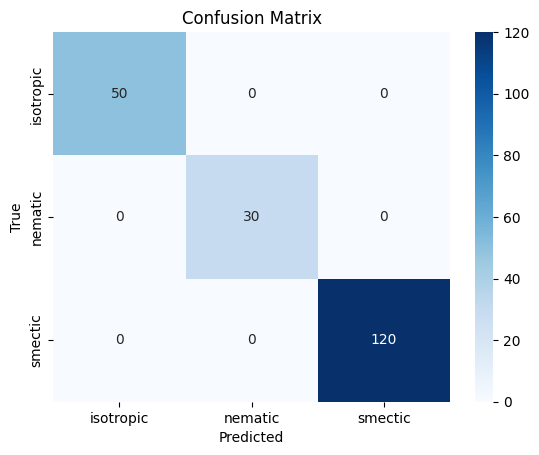

In [32]:
def test_model(model):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloaders['test']:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu())
            all_labels.extend(labels.cpu())

    print("\nTest Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    print("F1 Score (macro):", f1_score(all_labels, all_preds, average='macro'))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, cmap="Blues", fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Run test
test_model(model)


In [33]:
def train_model(model, epochs=10):
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        train_loss, correct = 0, 0

        for images, labels in dataloaders['train']:
            images, labels = images.to(model.device), labels.to(model.device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(output, 1)
            correct += (preds == labels).sum().item()

        avg_train_loss = train_loss / len(dataloaders['train'])
        val_acc = evaluate_model(model, 'val')

        train_losses.append(avg_train_loss)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {correct/len(datasets_dict['train']):.4f} | Val Acc: {val_acc:.4f}")

    return train_losses, val_accuracies

In [34]:
train_losses, val_accuracies = train_model(model, epochs=10)


Epoch 1/10
Train Loss: 0.0016 | Train Acc: 0.9991 | Val Acc: 1.0000

Epoch 2/10
Train Loss: 0.0048 | Train Acc: 0.9964 | Val Acc: 1.0000

Epoch 3/10
Train Loss: 0.0058 | Train Acc: 0.9973 | Val Acc: 1.0000

Epoch 4/10
Train Loss: 0.0015 | Train Acc: 0.9991 | Val Acc: 1.0000

Epoch 5/10
Train Loss: 0.0320 | Train Acc: 0.9955 | Val Acc: 0.9867

Epoch 6/10
Train Loss: 0.0574 | Train Acc: 0.9685 | Val Acc: 0.9967

Epoch 7/10
Train Loss: 0.0065 | Train Acc: 0.9955 | Val Acc: 1.0000

Epoch 8/10
Train Loss: 0.0169 | Train Acc: 0.9937 | Val Acc: 1.0000

Epoch 9/10
Train Loss: 0.0269 | Train Acc: 0.9910 | Val Acc: 1.0000

Epoch 10/10
Train Loss: 0.0253 | Train Acc: 0.9946 | Val Acc: 1.0000


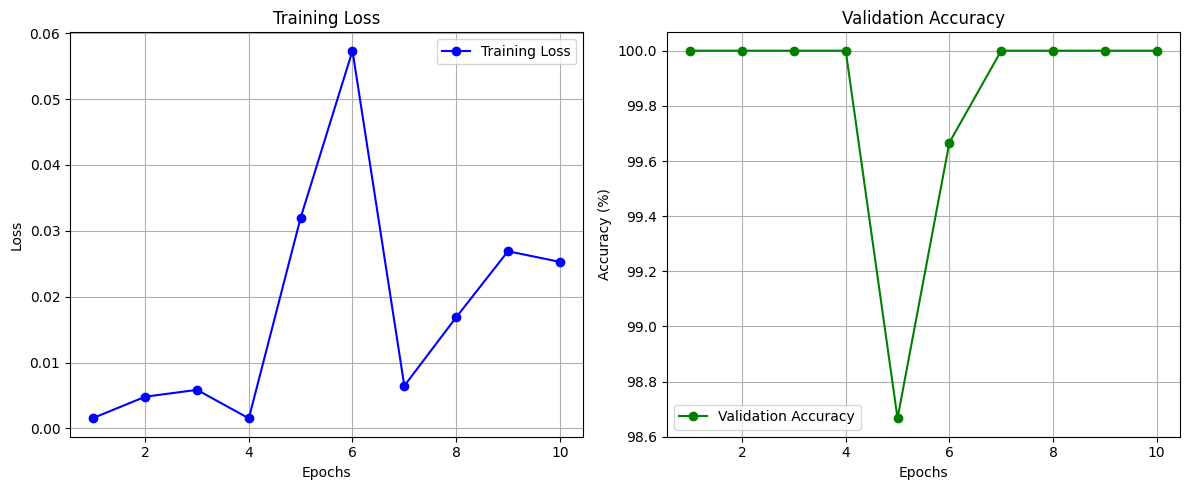

In [35]:
# Plotting training curves
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, 'b-o', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(epochs_range, [acc*100 for acc in val_accuracies], 'g-o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

from the loss plot over epochs -there is gradual spike indicating some hard examples of the liquid crystals phases during training which is reflected on validation accuracy 